In [1]:
# Import需要的套件
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time

In [13]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# 定义标签和类别字典以及常量 N
label_dict = {"apple": 0, "banana": 1, "tangerine": 2, "watermelon": 3}
class_dict = {0: "apple", 1: "banana", 2: "tangerine", 3: "watermelon"}
N = 4  # 总共四个类别

class MyDataset(Dataset):
    def __init__(self, data_dir, transform, loader):
        # 获取标签文件夹列表
        self.labels = [label for label in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, label))]
        
        # 获取图像路径和标签的配对列表
        self.data = []
        for label in self.labels:
            label_path = os.path.join(data_dir, label)
            for img_fn in os.listdir(label_path):
                img_path = os.path.join(label_path, img_fn)
                if not os.path.isdir(img_path):
                    self.data.append((img_path, label_dict[label]))

        self.transform = transform

    def __getitem__(self, index):
        img_path, label = self.data[index]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.data)

def load_data():
    print('data processing...')
    # 定义数据增强和预处理操作
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # 标准化
    ])
    
    # 数据路径（你需要根据自己的实际路径调整）
    data_dir = r"C:\Users\12705\Desktop\作业\大四\1\大作业\data_root_path"
    
    # 创建训练集和测试集的数据集实例
    full_dataset = MyDataset(data_dir, transform, loader=Image.open)

    # 按比例划分训练集和验证集
    train_size = int(len(full_dataset) * 0.8)
    validate_size = len(full_dataset) - train_size
    train, val = torch.utils.data.random_split(full_dataset, [train_size, validate_size])

    # 创建数据加载器
    train_data_loader = DataLoader(dataset=train, batch_size=50, shuffle=True, num_workers=0)
    val_data_loader = DataLoader(dataset=val, batch_size=50, shuffle=True, num_workers=0)
    test_data_loader = DataLoader(dataset=full_dataset, batch_size=50, shuffle=False, num_workers=0)

    return train_data_loader, val_data_loader, test_data_loader


In [6]:
import copy
import os
import random

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from classify.data_process import load_data
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from classify.decorator import metric_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置随机种子
def setup_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(20)

class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=4):  # 设置为 4 类
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.fc1 = nn.Linear(3 * 3 * 64, 64)  # 假设输入尺寸为224x224
        self.fc2 = nn.Linear(64, 4)  # 输出改为 4 类
        self.relu = nn.ReLU()
        self.out = nn.Linear(4, num_classes)  # 最终输出类别数


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)  # 展平操作，将卷积层输出展平
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.out(x)  # 不需要再加 Softmax 激活
        x = F.log_softmax(x, dim=1)  # 在输出上应用 LogSoftmax
        return x



def get_val_loss(model, Val):
    model.eval()  # Ensure model is in evaluation mode
    criterion = nn.CrossEntropyLoss().to(device)
    val_loss = []
    for (data, target) in Val:
        data, target = data.to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss.append(loss.cpu().item())
    return np.mean(val_loss)

@metric_time
def train():
    writer = SummaryWriter("log/")
    train_data_loader, val_data_loader, _ = load_data()
    print('Training...')
    epoch_num = 30
    best_model = None
    min_epochs = 5
    min_val_loss = float('inf')  # Initialize with a very large value
    model = cnn().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    criterion = nn.CrossEntropyLoss().to(device)
    
    # Optionally, add a learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)  # Adjust learning rate every 10 epochs

    for epoch in tqdm(range(epoch_num), ascii=True):
        model.train()
        train_loss = []
        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = data.to(device), target.long().to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.cpu().item())

        # Validation after each epoch
        val_loss = get_val_loss(model, val_data_loader)
        writer.add_scalar("val_loss", val_loss, epoch)
        
        if epoch + 1 > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)

        # Learning rate decay
        scheduler.step()

        tqdm.write(f'Epoch {epoch:03d} train_loss {np.mean(train_loss):.5f} val_loss {val_loss:.5f}')

    # Save the best model
    torch.save(best_model.state_dict(), "model/cnn.pkl")

@metric_time
def test():
    _, _, test_dataset = load_data()
    model = cnn().to(device)
    model.load_state_dict(torch.load("model/cnn.pkl"))
    
    model.eval()
    total = 0
    correct = 0
    for (data, target) in test_dataset:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')


In [7]:
train()

data processing...


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Training...


  3%|##7                                                                                | 1/30 [00:05<02:25,  5.02s/it]

Epoch 000 train_loss 0.68971 val_loss 0.70859


  7%|#####5                                                                             | 2/30 [00:10<02:26,  5.25s/it]

Epoch 001 train_loss 0.66893 val_loss 0.72885


 10%|########3                                                                          | 3/30 [00:15<02:20,  5.20s/it]

Epoch 002 train_loss 0.64521 val_loss 0.72516


 13%|###########                                                                        | 4/30 [00:20<02:14,  5.18s/it]

Epoch 003 train_loss 0.61849 val_loss 0.60768


 17%|#############8                                                                     | 5/30 [00:26<02:16,  5.48s/it]

Epoch 004 train_loss 0.59623 val_loss 0.61109


 20%|################6                                                                  | 6/30 [00:32<02:16,  5.69s/it]

Epoch 005 train_loss 0.57386 val_loss 0.60039


 23%|###################3                                                               | 7/30 [00:38<02:10,  5.66s/it]

Epoch 006 train_loss 0.54266 val_loss 0.55222


 27%|######################1                                                            | 8/30 [00:43<02:02,  5.58s/it]

Epoch 007 train_loss 0.54394 val_loss 0.62406


 30%|########################9                                                          | 9/30 [00:48<01:53,  5.42s/it]

Epoch 008 train_loss 0.52579 val_loss 0.58255


 33%|###########################3                                                      | 10/30 [00:53<01:45,  5.28s/it]

Epoch 009 train_loss 0.51832 val_loss 0.55364


 37%|##############################                                                    | 11/30 [00:58<01:39,  5.22s/it]

Epoch 010 train_loss 0.49651 val_loss 0.63108


 40%|################################8                                                 | 12/30 [01:04<01:33,  5.18s/it]

Epoch 011 train_loss 0.48868 val_loss 0.54007


 43%|###################################5                                              | 13/30 [01:09<01:27,  5.13s/it]

Epoch 012 train_loss 0.48575 val_loss 0.52053


 47%|######################################2                                           | 14/30 [01:14<01:21,  5.11s/it]

Epoch 013 train_loss 0.46654 val_loss 0.57047


 50%|#########################################                                         | 15/30 [01:19<01:16,  5.08s/it]

Epoch 014 train_loss 0.45445 val_loss 0.54755


 53%|###########################################7                                      | 16/30 [01:24<01:11,  5.11s/it]

Epoch 015 train_loss 0.46787 val_loss 0.57985


 57%|##############################################4                                   | 17/30 [01:29<01:06,  5.13s/it]

Epoch 016 train_loss 0.45395 val_loss 0.55991


 60%|#################################################1                                | 18/30 [01:34<01:01,  5.10s/it]

Epoch 017 train_loss 0.44553 val_loss 0.60963


 63%|###################################################9                              | 19/30 [01:39<00:55,  5.09s/it]

Epoch 018 train_loss 0.43191 val_loss 0.55302


 67%|######################################################6                           | 20/30 [01:44<00:50,  5.08s/it]

Epoch 019 train_loss 0.43619 val_loss 0.52383


 70%|#########################################################4                        | 21/30 [01:49<00:45,  5.07s/it]

Epoch 020 train_loss 0.43588 val_loss 0.63879


 73%|############################################################1                     | 22/30 [01:54<00:40,  5.04s/it]

Epoch 021 train_loss 0.42275 val_loss 0.52372


 77%|##############################################################8                   | 23/30 [01:59<00:35,  5.03s/it]

Epoch 022 train_loss 0.41151 val_loss 0.55405


 80%|#################################################################6                | 24/30 [02:04<00:30,  5.05s/it]

Epoch 023 train_loss 0.41282 val_loss 0.54612


 83%|####################################################################3             | 25/30 [02:09<00:25,  5.04s/it]

Epoch 024 train_loss 0.40672 val_loss 0.53595


 87%|#######################################################################           | 26/30 [02:14<00:20,  5.03s/it]

Epoch 025 train_loss 0.40699 val_loss 0.52924


 90%|#########################################################################8        | 27/30 [02:19<00:15,  5.02s/it]

Epoch 026 train_loss 0.40149 val_loss 0.59598


 93%|############################################################################5     | 28/30 [02:24<00:10,  5.03s/it]

Epoch 027 train_loss 0.40738 val_loss 0.52507


 97%|###############################################################################2  | 29/30 [02:29<00:05,  5.03s/it]

Epoch 028 train_loss 0.39538 val_loss 0.54502


100%|##################################################################################| 30/30 [02:34<00:00,  5.16s/it]
2024-11-22 09:37:47.427 | DEBUG    | classify.decorator:wrapper:13 - train运行时间: 158.84003901481628 s


Epoch 029 train_loss 0.40324 val_loss 0.55505


In [8]:
nn.Softmax

torch.nn.modules.activation.Softmax

In [9]:
test()

data processing...


2024-11-22 09:38:31.228 | DEBUG    | classify.decorator:wrapper:13 - test运行时间: 7.543529272079468 s


Accuracy: 83.20%


Predicted class: dogs, Output: tensor([[-0.6941, -0.6922]], grad_fn=<LogSoftmaxBackward0>)


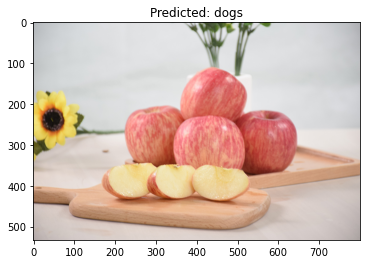

In [11]:
import unittest
from PIL import Image
import torch
from matplotlib import pyplot as plt
from torchvision import transforms

# 假设cnn模型定义在 classify/cnn.py 中
from classify.cnn import cnn
# 假设类别字典定义在 classify/data_process.py 中
from classify.data_process import class_dict

# 自动选择设备：如果有可用的GPU则使用GPU，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建模型并加载训练好的权重
model = cnn().to(device)
model.load_state_dict(torch.load("model/cnn.pkl", map_location=device), strict=False)
model.eval()

# 测试图像路径，替换为你的实际图像路径
_img_path = r"data_root_path\apple\01a8aacc4ce4260c9c0dcb4795568559.jpg"

# 定义图像预处理（包括调整尺寸、转换为Tensor、标准化）
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # 标准化
])

# 打开并预处理图像
img = Image.open(_img_path).convert('RGB')
img_transform = transform(img).unsqueeze(0).to(device)  # 加载到正确的设备并模拟批样本

# 进行推理
output = model(img_transform)

# 获取预测结果，输出最大值的类别
_, predicted = torch.max(output, 1)

# 获取类别名称
predicted_class = class_dict[predicted.item()]

print(f"Predicted class: {predicted_class}, Output: {output}")

# 可选：可视化图像和输出结果
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.show()
